## Simple NN experiment

### 1. Preprocessing

Importing the libraries

In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D 
from keras.layers.convolutional import MaxPooling2D 
from keras.layers import Flatten 
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical
from keras import backend as K
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import argparse
import random
import pickle
import cv2
import os

Using TensorFlow backend.


In [2]:
path = "C:\\Users\\mreun\\Moles"

In [3]:
# Let's define the size of imported images
height = 256
width = 256

epoch = 50 #epoch number for training the model

In [4]:
# Initializing data and labels
data = []
labels = []

In [5]:
imagePaths = sorted(list(paths.list_images(path)))
random.seed(42)
random.shuffle(imagePaths)

In [6]:
# Cycle for downloading images
for imagePath in imagePaths:
    # loading image, changing the size to 64x64 pixels 
    # adding to the list
    image = cv2.imread(imagePath)
    image = np.array(cv2.resize(image, (height, width))).flatten()
    data.append(image)

    # retrieving the label from the path 
    # adding to the list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [7]:
# normalizing pixels to the range from 0 to 1
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [9]:
# transforming labels into 0 and 1 and then to vectors

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
num_classes = y_test.shape[1]
num_pixels = X_train.shape[1]  # find size of one-dimensional vector

In [11]:
data.shape

(5335, 196608)

### 2. Training the model

In [12]:
def simple_NN():

    model = Sequential()
    model.add(Dense(1024, input_shape=(num_pixels,), activation="sigmoid"))
    model.add(Dense(512, activation="sigmoid"))
    model.add(Dense(num_classes, activation="softmax"))

    opt = SGD(lr=0.01)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [13]:
# build the model
model = simple_NN()

In [14]:
checkpointer = ModelCheckpoint(filepath='Saved_models/weights.best.SNN.hdf5', 
                               verbose=1, 
                               save_best_only=True)
# fit the model
History_SNN = model.fit(X_train, y_train, 
              validation_data=(X_test, y_test), 
              epochs=epoch, 
              callbacks=[checkpointer],
              verbose=1)

# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

Train on 4268 samples, validate on 1067 samples
Epoch 1/50
4268/4268 [==============================] - 212s 50ms/step - loss: 0.6841 - accuracy: 0.5933 - val_loss: 0.6829 - val_accuracy: 0.5698

Epoch 00001: val_loss improved from inf to 0.68293, saving model to Saved_models/weights.best.SNN.hdf5
Epoch 2/50
4268/4268 [==============================] - 206s 48ms/step - loss: 0.6480 - accuracy: 0.6162 - val_loss: 0.6120 - val_accuracy: 0.7104

Epoch 00002: val_loss improved from 0.68293 to 0.61195, saving model to Saved_models/weights.best.SNN.hdf5
Epoch 3/50
4268/4268 [==============================] - 208s 49ms/step - loss: 0.6205 - accuracy: 0.6455 - val_loss: 0.6727 - val_accuracy: 0.6654

Epoch 00003: val_loss did not improve from 0.61195
Epoch 4/50
4268/4268 [==============================] - 210s 49ms/step - loss: 0.6205 - accuracy: 0.6509 - val_loss: 0.7050 - val_accuracy: 0.5961

Epoch 00004: val_loss did not improve from 0.61195
Epoch 5/50
4268/4268 [==========================

In [15]:
# Loading the weights
model.load_weights("./Saved_models/weights.best.SNN.hdf5")

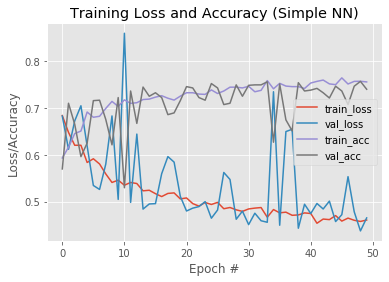

In [16]:
N = np.arange(0, epoch)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, History_SNN.history["loss"], label="train_loss")
plt.plot(N, History_SNN.history["val_loss"], label="val_loss")
plt.plot(N, History_SNN.history["accuracy"], label="train_acc")
plt.plot(N, History_SNN.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## 3. Prediction

In [14]:
# Let's upload test set the same way as it was done for training

path_test = "C:\\Users\\mreun\\Test"
imagePaths_test = sorted(list(paths.list_images(path_test)))

In [15]:
data_test = []
label_test = []
predictions = []

In [16]:
for imagePath in imagePaths_test:

    image = cv2.imread(imagePath)
    image = np.array(cv2.resize(image, (height, width))).flatten()
    data_test.append(image)

    label = imagePath.split(os.path.sep)[-2]
    label_test.append(label)

In [17]:
data_test = np.array(data_test, dtype="float32") / 255.0
label_test = np.array(label_test)

In [18]:
def predict(image, 
            model_architecture = model, 
            path_model_weight = "./Saved_models/weights.best.SNN.hdf5"):

    # Getting the model's architecture
    model = model_architecture
    # Loading the weights from the file
    model.load_weights(path_model_weight)
    # Predicting
    pred = model.predict(image)
    for_df = [pred[0][0], pred[0][1]]
    predictions.append(for_df)
    if np.argmax(pred) == 0:
        return [1., 0.]
    elif np.argmax(pred) == 1:
        return [0., 1.]

In [19]:
y_test_pred = lb.transform(label_test)
y_true = to_categorical(y_test_pred) 

number_test = len(data_test)

## 4. Evaluating the model

In [20]:
def compute_roc(y_true, y_score):
    
    # Computing ROC curve and area
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_score) 
    auroc = auc(false_positive_rate, true_positive_rate) 
    return false_positive_rate, true_positive_rate, auroc

In [21]:
def plot_roc(y_true, y_score):

    # Ploting ROC curve
 
    false_positive_rate, true_positive_rate, auroc = compute_roc(y_true, y_score)
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.plot(false_positive_rate, 
             true_positive_rate, 
             color='darkorange',
             lw=2, 
             label='ROC curve (area = {:.2f})'.format(auroc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic example', fontsize=15)
    plt.legend(loc="lower right", fontsize=14)
    plt.show()
    
plt.style.use("seaborn-white")

In [22]:
weight_path = "./Saved_models/weights.best.SNN.hdf5"

In [23]:
y_score_SNN = []
for index in range(number_test): 
    probs = predict(image = np.expand_dims(data_test[index], axis=0), model_architecture = model, 
            path_model_weight = weight_path)
    y_score_SNN.append(probs)
    
correct = np.array(y_true) == np.array(y_score_SNN)

In [24]:
df_correct = pd.DataFrame(y_score_SNN, columns = ["Non-melanoma_real","Melanoma_real"])
df_prediction_SNN = pd.DataFrame(predictions, columns = ["Non-melanoma_prediction","Melanoma_prediction"])
df_merged=pd.concat([df_correct, df_prediction_SNN],axis=1)

In [25]:
df_merged.head(10)

,Non-melanoma_real,Melanoma_real,Non-melanoma_prediction,Melanoma_prediction
0,1.0,0.0,0.989960,0.010040
1,1.0,0.0,0.969519,0.030481
2,0.0,1.0,0.479847,0.520153
3,1.0,0.0,0.981223,0.018777
4,1.0,0.0,0.986151,0.013849
5,1.0,0.0,0.965979,0.034021
6,1.0,0.0,0.979616,0.020384
7,1.0,0.0,0.619713,0.380287
8,1.0,0.0,0.987537,0.012463
9,1.0,0.0,0.761885,0.238115


In [26]:
print("Accuracy = %2.2f%%" % (np.mean(correct)*100))

Accuracy = 71.50%


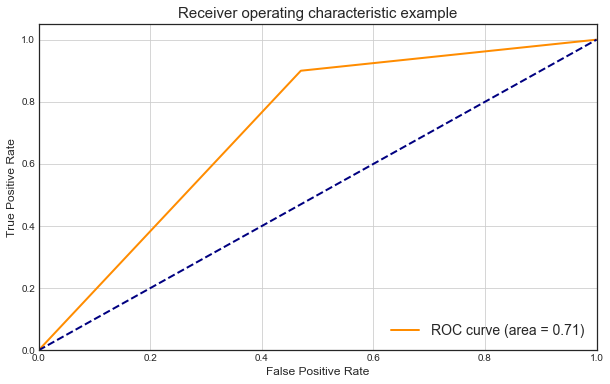

In [27]:
# Re-ordering the actual y (for ROC)
y_true_2 = []
for i in range(len(y_true)):
    y_true_2.append(y_true[i][0])
    
y_score_2 = []
for i in range(len(y_score_SNN)):
    y_score_2.append(y_score_SNN[i][0])

plot_roc(y_true_2, y_score_2)

In [28]:
def positive_negative_measurement(y_true, y_score_SNN):
    # Initialization
    TRUE_POSITIVE = 0
    FALSE_POSITIVE = 0
    TRUE_NEGATIVE = 0
    FALSE_NEGATIVE = 0
    
    # Calculating the model
    for i in range(len(y_score_SNN)):
        if y_true[i] == y_score_SNN[i] == 1:
            TRUE_POSITIVE += 1
        if (y_score_SNN[i] == 1) and (y_true[i] != y_score_SNN[i]):
            FALSE_POSITIVE += 1
        if y_true[i] == y_score_SNN[i] == 0:
            TRUE_NEGATIVE += 1
        if (y_score_SNN[i] == 0) and (y_true[i] != y_score_SNN[i]):
            FALSE_NEGATIVE += 1

    return(TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE)

In [29]:
TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE = positive_negative_measurement(y_true_2, y_score_2)
postives_negatives = [[TRUE_POSITIVE, FALSE_POSITIVE], 
                      [FALSE_NEGATIVE, TRUE_NEGATIVE]]

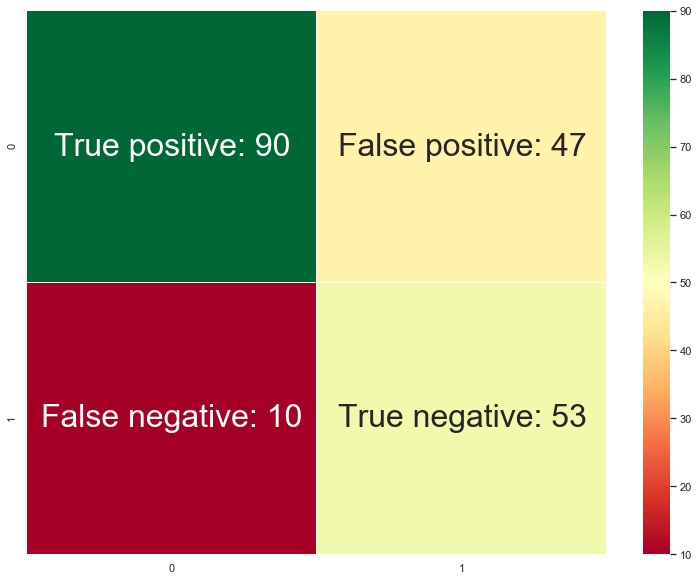

In [31]:
import seaborn as sns
sns.set()
labels =  np.array([['True positive: ' + str(TRUE_POSITIVE),
                     'False positive: ' + str(FALSE_POSITIVE)],
                    ['False negative: ' + str(FALSE_NEGATIVE),
                     'True negative: ' + str(TRUE_NEGATIVE)]])
plt.figure(figsize = (13, 10))
sns.heatmap(postives_negatives, annot = labels, linewidths = 0.1, fmt="", cmap = 'RdYlGn', annot_kws={"size":32})

In [47]:
sensitivity = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_NEGATIVE)
specifity = TRUE_NEGATIVE / (TRUE_NEGATIVE + FALSE_NEGATIVE)
precision = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_POSITIVE)
accuracy = (TRUE_POSITIVE + TRUE_NEGATIVE) / (TRUE_POSITIVE + FALSE_POSITIVE + TRUE_NEGATIVE + FALSE_NEGATIVE)
name = "SNN"
scores_SNN = [name, sensitivity, specifity, precision, accuracy]

In [48]:
sensitivity = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_NEGATIVE)
specifity = TRUE_NEGATIVE / (TRUE_NEGATIVE + FALSE_NEGATIVE)
precision = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_POSITIVE)
accuracy = (TRUE_POSITIVE + TRUE_NEGATIVE) / (TRUE_POSITIVE + FALSE_POSITIVE + TRUE_NEGATIVE + FALSE_NEGATIVE)
name = "SNN"
scores_SNN = [SNN, 0.9, 0.84127, 0.656934, 0.715]

In [ ]:
scores_SNN = [name, sensitivity, specifity, precision, accuracy]

In [50]:
df_scores_SNN = pd.DataFrame([scores_SNN], columns = ["Model",  "Sensitivity",  "Specifity",  "Precision", "Accuracy"])
df_scores_SNN

,Model,Sensitivity,Specifity,Precision,Accuracy
0,SNN,0.9,0.84127,0.656934,0.715
